# Set up

## Imports

In [27]:
# --- Standard library ---
import os
import subprocess
from time import perf_counter as pc

# --- Scientific ---
import numpy as np  # General computational tools

# --- Network science ---
import networkx as nx
from node2vec import Node2Vec as N2V  # Embedding tools

# --- Data handling and visualization ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Functions

In [28]:
def read_file(filename):
    G = {}

    with open(filename) as file:
        for line in file:
            data = line.strip().split()
            l = int(data[0])
            n = int(data[1])
            m = int(data[2])
            if l not in G:
                G[l] = nx.Graph()
            G[l].add_edge(n, m)

    return G

def generate_LFR(N, avgk, gamma, tau, mu):
    # Generate LFR benchmark
    subprocess.call(
        " ".join([
            "../../bin/LFR/benchmark.sh",
            "-N", f"{N}",
            "-k", f"{avgk}",
            "-maxk", f"{np.sqrt(N)}",
            "-t1", f"{gamma}",
            "-t2", f"{tau}",
            "-mu", f"{mu}"
        ]),
        stdout=open(os.devnull, 'w'),
        stderr=open(os.devnull, 'w'),
        shell=True
    )

    x=np.loadtxt('../../bin/LFR/network.dat')
    edges=[(int(x[i][0])-1,int(x[i][1])-1) for i in range(len(x))]
    g=nx.Graph(edges)

    return g

In [29]:
def embed_graph(g):
    N2V(g, dimensions=128, walk_length=30, num_walks=100, workers=4, quiet=True).fit()

def time_embedding(g):
    start = pc()
    embed_graph(g)
    return pc() - start

## Globals

In [25]:
Ns = np.logspace(2, 5, num=6, endpoint=True)
gamma = 2.1
tau = 1.0
mu = 0.1
avgk = 20

# Sweep w.r.t. N

In [26]:
times = []
Ns_axis = []
for N in Ns:
    for _ in range(5):
        Ns_axis.append(N)
        g = generate_LFR(N, avgk, gamma, tau, mu)
        times.append(time_embedding(g))

KeyboardInterrupt: 

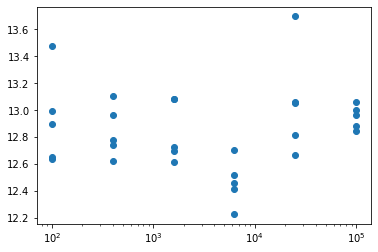

In [ ]:
plt.scatter(Ns_axis, times)
plt.xscale("log")



plt.savefig("initial_n2v_profiling.png", facecolor="white", transparent=False)

# Real Corpus

===== Starting profiling =====
Layer 1 of 13
Layer 2 of 13
Layer 3 of 13
Layer 4 of 13
Layer 5 of 13
Layer 6 of 13
Layer 7 of 13
Layer 8 of 13
Layer 9 of 13
Layer 10 of 13
Layer 11 of 13
Layer 12 of 13
Layer 13 of 13
===== Completed profiling =====


<Figure size 864x648 with 0 Axes>

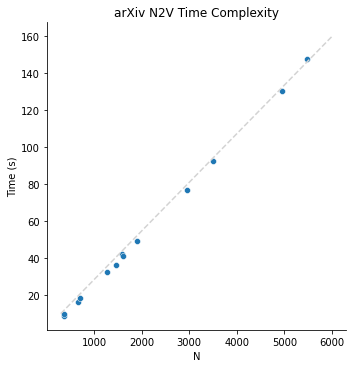

In [30]:
system = "arxiv"
records = []

G = read_file(f"../../data/input/preprocessed/real/duplex_system={system}.edgelist")
layers_ = len(G)

print("===== Starting profiling =====")
for layer in G:
    print(f"Layer {layer} of {layers_}")
    g = G[layer]
    N = g.number_of_nodes()

    time = time_embedding(g)

    records.append({
        "N": N,
        "Layer": layer,
        "Time": time
    })
print("===== Completed profiling =====")

df = pd.DataFrame.from_records(records)

# Timing scatter
plt.figure(figsize=(12, 9))
sns.relplot(
    data=df, kind="scatter",
    x="N", y="Time",
)

# Reference line (eyeballed)
plt.plot([300, 6000], [10, 160], color="lightgray", linestyle="--")

# Figure tidying
plt.ylabel("Time (s)")
plt.title("arXiv N2V Time Complexity")

# Save to disk
plt.savefig(f"n2v-profiling_system={system}.png", facecolor="white", transparent=False)

<Figure size 864x648 with 0 Axes>

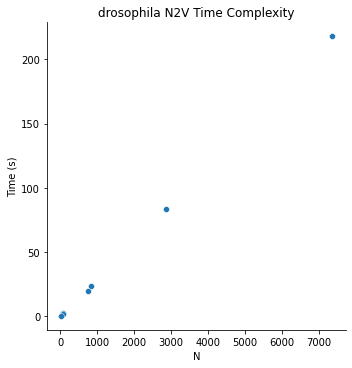

In [32]:
system = "drosophila"
records = []

G = read_file(f"../../data/input/preprocessed/real/duplex_system={system}.edgelist")
layers_ = len(G)

print("===== Starting profiling =====")
for layer in G:
    print(f"Layer {layer} of {layers_}")
    g = G[layer]
    N = g.number_of_nodes()

    time = time_embedding(g)

    records.append({
        "N": N,
        "Layer": layer,
        "Time": time
    })
print("===== Completed profiling =====")

df = pd.DataFrame.from_records(records)

# Timing scatter
plt.figure(figsize=(12, 9))
sns.relplot(
    data=df, kind="scatter",
    x="N", y="Time",
)

# Reference line (eyeballed)
# plt.plot([300, 6000], [10, 160], color="lightgray", linestyle="--")

# Figure tidying
plt.ylabel("Time (s)")
plt.title(f"{system} N2V Time Complexity")

# Save to disk
plt.savefig(f"n2v-profiling_system={system}.png", facecolor="white", transparent=False)